# 广州商学院 -- 基于神经网络的垃圾分类

>垃圾分类，一般是指按一定规定或标准将垃圾分类储存、分类投放和分类搬运，从而转变成公共资源的一系列活动的总称。分类的目的是提高垃圾的资源价值和经济价值，力争物尽其用。垃圾分为四类，分别是有害垃圾、厨余垃圾、可回收物和其他垃圾，其对应的垃圾桶颜色分别是红、绿、蓝、黑。
![](img/q1.png)

**垃圾分类的意义：**

1. 提高了废品回收利用的比例，能源再生，减少了原材料的需求，减少二氧化碳的排放。

2. 将易腐有机成分为主的厨房垃圾单独分类，为垃圾堆肥提供优质原料，生产出优质的有机肥，这样有利于改善土壤肥力，减少化肥施用量。

3. 普及环保与垃圾的知识，提升全社会对环卫行业的认知，减少环卫工人的工作难度，形成尊重、关心环卫工人的氛围。

4. 把有害垃圾分类出来，减少了垃圾中的重金属、有机污染物、致病菌的含量，有利于垃圾的无害化处理，减少了垃圾处理的水、土壤、大气污染风险。

## 数据集介绍

- 本次项目使用的数据集包括硬纸板、玻璃制品、肉类、纸制品、塑料和废物垃圾等 `6` 种常见的生活垃圾共计 `2,247` 张。
- 项目分为 3 部分。数据处理、模型建立和模型测试。
- 经过迭代模型的100次训练后在训练集上准确率达到 `89.89%` 左右，在验证集上准确率达到 `77.68%` 左右。

![](./img/trainingset.png)

# 项目实现

<img src="./img/mx.png" width="80%">

# 1、导入依赖库

In [1]:
import numpy as np                        # 导入 numpy 库处理数组
import matplotlib.pyplot as plt           # 导入 matplotlib魔术工具中的 pyplot 绘图模块 
import tensorflow as tf                   # 导入 tensorflow 2.3.0 版本， 原2.5.0

# ImageDataGenerator数据生成器 ；load_img 把图像加载到 PIL 格式 ；img_to_array将 PIL 映像实例转换为 Numpy 数组 ；array_to_img 将 3D Numpy 数组转换为 PIL 映像实例
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Conv2D（二维卷积层） ；Flatten （平坦层） ；MaxPooling2D（为空域信号施加最大值池化层） ；Dense（全连接层）
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense

# 导入Sequential（ 顺序/序贯模型）；通过堆叠许多层，构建出深度神经网络。
from tensorflow.keras.models import Sequential

# 回调，防止出现过拟合
from tensorflow.keras.callbacks import EarlyStopping

# keras自带的类似于一个归一化的函数
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# 【python】glob模块、os模块
import glob, os, random

# 模型部署  保存模型的结构为json格式（只保存模型的结构architecture（没有weights和训练的配置configurations））
from tensorflow.keras.models import model_from_json

# 图像预处理
from tensorflow.keras.preprocessing import image

# 从keras.optimizers中导入SGD（优化器）
from tensorflow.keras.optimizers import SGD                                                

In [2]:
# 查看当前 TensorFlow 版本
print(tf.__version__)

2.5.0


### 路径定义

In [3]:
# 设置根目录路径，同时创建一个字典，使用字典的键来表示各垃圾类别
# 垃圾的 六分类 问题
root_path = './'

#         0：硬纸板     1：玻璃制品   2：肉制品  3：纸制品   4：塑料制品   5：废品垃圾    
labels = {0: 'cardboard', 1: 'glass', 2: 'meat', 3: 'paper', 4: 'plastic', 5: 'trash'}

# 2、数据处理与训练样本扩充
在本次垃圾分类识别的实现上，我采用了一份样本比较小的数据集进行垃圾图像分类模型的训练，要获得几百或几千张属于你所感兴趣的类别的训练图像往往不是一件容易的事情。我在这里使用的数据扩充，就是其中一种最常用的解决小规模数据集进行深度学习的方法。为了充分利用我们的一些训练例子，我们将通过一系列的随机变换『增强』它们，从而让我们的模型绝不会两次看到完全相同的图像，这有助于防止过度拟合并帮助模型归一化。我使用了 ImageDataGenerator 类，通过实时数据增强生成张量图像数据批次。 ImageDataGenerator 类包含了许多图片预处理参数，例如：rescale 可以实现图片像素归一化。同时，为了防止模型过拟合，可以采取一些数据增强（Data augmentation）操作：水平翻转、垂直旋转等。

In [4]:
# 构造ImageDataGenerator对象（数据生成器）  包含了许多图片预处理参数
train_datagen = ImageDataGenerator(
    rescale=1. / 255,                   # 数据缩放，把像素点的值除以255，使之在0到1之间
    shear_range=0.1,                    # 错切变换角度
    zoom_range=0.1,                     # 随机缩放范围
    width_shift_range = 0.1,            # 除以总宽度的值
    height_shift_range = 0.1,           # 除以总高度的值
    horizontal_flip=True,               # 随机水平暗转
    vertical_flip = True,               # 随机垂直翻转
    validation_split = 0.1              # 保留用于验证的图像比例为0.1
)
# 归一化验证集
val_datagen = ImageDataGenerator(
    rescale=1. / 255,                  # 数据缩放，把像素点的值除以255，使之在0到1之间
    validation_split=0.1)              # 保留用于验证的图像比例为0.1



# 采用数据扩充策略，防止模型过拟合

# 对训练集进行数据增强（Data augmentation）
train_generator = train_datagen.flow_from_directory(
    root_path+'/dataset',              # 目标数据的路径
    target_size=(300, 300),            # 所有的图片将被调整的尺寸
    batch_size=8,                      # 每批传入数据的大小
    class_mode='categorical',          # 决定返回标签的类型。这里采用 2D one-hot 编码标签
    subset='training',                 # 数据子集
    seed=0)                            # 可选随机种子

# 对测试集进行数据增强（Data augmentation）
val_generator = val_datagen.flow_from_directory(
    root_path+'/dataset',              # 目标数据的路径
    target_size=(300, 300),            # 所有的图片将被调整的尺寸
    batch_size=8,                      # 每批传入数据的大小
    class_mode='categorical',          # 决定返回标签的类型。这里采用 2D one-hot 编码标签
    subset='validation',               # 数据子集
    seed=0)                            # 可选随机种子

Found 2024 images belonging to 6 classes.
Found 223 images belonging to 6 classes.


**发现 2024 张属于 6 类的图像
 发现 223 幅图像分为 6 类**

# 3、模型创建
keras 中的主要数据结构是 model（模型），它提供定义完整计算图的方法。通过将图层添加到现有模型/计算图，我们可以构建出复杂的神经网络。Keras 有两种不同的构建模型的方法：

- Sequential models（Sequential 顺序/序贯模型）
- Functional API（使用函数式 API 的 Model 类模型）

Sequential 模型字面上的翻译是顺序模型，给人的感觉是种简单的线性模型，顺序模型各层之间是依次顺序的线性关系,是多个网络层的线性堆栈.但实际上 Sequential 模型可以构建非常复杂的神经网络，包括全连接神经网络、卷积神经网络 (CNN)、循环神经网络 (RNN)、等等。这里的 Sequential 更准确的应该理解为堆叠，通过堆叠许多层，构建出深度神经网络。Sequential 模型的核心操作是添加 layers（图层）。本案例中，我们还将一些流行的图层添加到模型中：

### 3.1 添加卷积层（输入层）
从我们所学习到的深度学习知识可以知道，深度学习通常包括定义模型、定义优化目标、输入数据、训练模型，最后通常还需要使用测试数据评估模型的性能。keras 中的 Sequential 模型构建也包含这些步骤。首先，网络的第一层是输入层，读取训练数据。为此，我们需要指定为网络提供的训练数据的大小，这里 input_shape 参数用于指定输入数据的形状：

`model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)))`

上面的代码中，输入层是卷积神经网络使用最常见的二维卷积层，它有高和宽两个空间维度，常用来处理图像数据。其获取 300，300, 3 的输入图像，即 `300 x 300 RGB 3 通道`。

### 3.2 添加最大池化层
`model.add(MaxPooling2D(pool_size=2))`

池化过程在一般卷积过程后。池化（pooling） 的本质，其实就是采样。Pooling 对于输入的 Feature Map，选择某种方式对其进行降维压缩，以加快运算速度。上面的代码中，我们采用应用较多的一种池化过程叫最大池化（Max Pooling）。

### 3.3 添加展平层（Flatten）
`model.add(Flatten())`

展平层用于输入层或者卷积层和全连接层中间，其目的在于将数据展平为适合神经网络的结构。

### 3.4 添加全连接层
`model.add(Dense(64, activation='relu'))`

全连接层在整个网络卷积神经网络中起到『分类器』的作用，把特征整合到一起，交给最后的分类器或者回归。

### 3.5 输出模型各层参数
最后，通过 model.summary() 输出模型概述信息，其中最重要的信息是模型各层的参数状况，在本案例中，我们的模型共有 `711,110` 个参数。

`model.summary()`

In [5]:
model = Sequential()

# 添加卷积层（输入层）
# filter表示卷积滤波器个数为32                    kernel_size表示所有空间维度指定相同的值
# padding='same'表示 padding 完尺寸与原来相同     activation='relu'使用relu作为激活函数
# input_shape=(300, 300, 3)表示输入图像的尺寸为300x300，且有3个颜色通道
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)))

# 池化层
# 使用最大池化层，且最大池化的窗口为2
model.add(MaxPooling2D(pool_size=2))

# 卷积
# 池化
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())  # 扁平化参数


# 全连接层作为『分类器』的作用，把特征整合到一起，交给最后的分类器或者回归
#  输出的空间维度为64（神经元），激活函数采用relu
model.add(Dense(64, activation='relu'))

# 全连接层  输出的空间维度为6 【由于本次垃圾分类为一个六分类问题，所以这里神经元设置为 6】
# 激活函数采用softmax
model.add(Dense(6, activation='softmax'))

# 完成架构搭建后，最后输出模型汇总 【共有 711,110 个参数】
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        9

- 总参数：711110
- 可培训参数：711110
- 不可训练参数：0

### 3.6 模型结构

可以看出，最后我们得到了一个：

`二维卷积（输入）-> 最大池化 -> 二维卷积 -> 最大池化 -> 二维卷积 -> 最大池化 -> 二维卷积 -> 最大池化 - 展平 -> 全连接 -> 全连接（输出）`

的深度神经网络结构。之后对其进行编译、训练与评估。

![Alt text](./img/mx2.png)

## 编译网络（损失函数）

In [6]:
# 编译模型需要定义两个参数：交叉熵损失函数 (categorical_crossentropy) 和 自适应矩估计（adam）优化器
model.compile(loss='categorical_crossentropy',           # 损失函数使用交叉熵
                   optimizer='adam',                     # 设置优化器  (梯度优化的算法)
                   metrics=['accuracy'])                 # 设置评估指标为准确率

## 网络训练（时间记录）

In [7]:
import time                                             # 记录模型训练时间  （第 14 周课程内容 数据分析）
start = time.time()                                     # 记录训练开始时间

history_fit = model.fit(train_generator,                # 增强的数据集
                        epochs=50,                      # 迭代总轮数，这里设置为50次，可以在实验时增加epoch次数，提升准确率
                        steps_per_epoch=2276//32,       # generator 产生的总步数（批次样本）
                        validation_data=val_generator,  # 验证数据的生成器
                        validation_steps=251//32)       # 在停止前 generator 生成的总步数（样本批数） 验证数据集/size值32

end = time.time()                                       # 记录训练结束时间
print('训练耗时：',end - start, '秒')                   # 打印显示过程耗时

Epoch 1/50
71/71 [==============================] - 45s 619ms/step - loss: 1.6902 - accuracy: 0.2729 - val_loss: 1.6216 - val_accuracy: 0.1429
Epoch 2/50
71/71 [==============================] - 49s 688ms/step - loss: 1.5253 - accuracy: 0.3415 - val_loss: 1.6060 - val_accuracy: 0.3036
Epoch 3/50
71/71 [==============================] - 46s 642ms/step - loss: 1.4253 - accuracy: 0.3944 - val_loss: 1.4492 - val_accuracy: 0.4464
Epoch 4/50
71/71 [==============================] - 49s 696ms/step - loss: 1.3792 - accuracy: 0.3715 - val_loss: 1.3895 - val_accuracy: 0.4107
Epoch 5/50
71/71 [==============================] - 67s 940ms/step - loss: 1.4093 - accuracy: 0.3891 - val_loss: 1.2161 - val_accuracy: 0.5000
Epoch 6/50
71/71 [==============================] - 50s 705ms/step - loss: 1.3385 - accuracy: 0.4085 - val_loss: 1.2672 - val_accuracy: 0.4107
Epoch 7/50
71/71 [==============================] - 53s 740ms/step - loss: 1.2626 - accuracy: 0.4736 - val_loss: 1.3090 - val_accuracy: 0.4107

- 这里我们可以看到在经过23分钟的训练后，训练集准确率0.69     测试集准确率0.70

### 准确率和损失值的可视化
进行模型训练时，同步记录了训练集和测试集的损失和准确率，并且将历史记录另存为字典，以备日后绘制损失或准确率时使用。

In [8]:
# 将训练过程的中间信息保留位json文件
with open(root_path + "/model/history_fit.json", "w") as json_file:
    json_file.write(str(history_fit))

进行准确率和损失值的可视化，将 acc 和 loss 使用 matplotlib Python 库画出来。

In [9]:
# 训练集
# 查看训练过程的准确率变化情况
acc = history_fit.history['accuracy']
# 查看验证过程的准确率变化情况
val_acc = history_fit.history['val_accuracy']

# 测试集
# 查看训练过程的损失值变化情况
loss = history_fit.history['loss']
# 查看验证过程的损失值变化情况
val_loss = history_fit.history['val_loss']

分别对训练集与测试集的准确率对比、以及训练集与与测试集的损失值对比进行画图

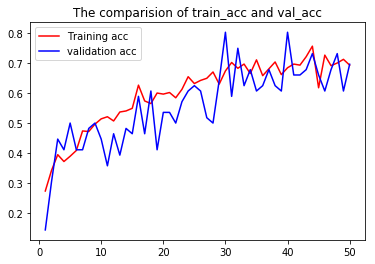

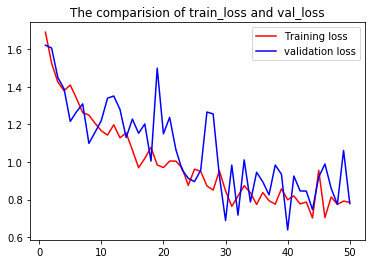

In [10]:
# 可视化训练集和验证集准确率的变化情况
epochs = range(1, len(acc) + 1) 

# 第一张图显示训练集和验证集上  准确率  随迭代次数的变化情况
plt.figure("acc")
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('The comparision of train_acc and val_acc')
plt.legend()
plt.show()


# 第二张图显示在训练集和验证集上的  损失值  的变化情况
plt.figure("loss")
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('The comparision of train_loss and val_loss')
plt.legend()
plt.show()

## 4. 模型测试
### 4.1 模型保存
模型测试前，首先要保存并重加载模型。

In [11]:
#  仅保存架构/配置，通常保存为 JSON 文件
model_json=model.to_json()
with open(root_path+'/model/model_json.json', "w") as json_file:
    json_file.write(model_json)

In [12]:
# 仅保存权重值使用 save_weights （通常在训练模型时使用）
model.save_weights(root_path+'/model/model_weight.h5')

In [13]:
# 将整个模型保存使用save （标准：以 TensorFlow SavedModel 格式（或较早的 Keras H5 格式）保存到单个归档）
model.save(root_path+'/model/model.h5')
print('model saved')

model saved


### 4.2 模型加载
将上一步保存的模型架构与权重值重新加载。

In [14]:
json_file = open(root_path + '/model/model_json.json')      # 加载模型结构文件
loaded_model_json = json_file.read()                        # read( )读取文件
json_file.close()
model = model_from_json(loaded_model_json)                  # 结构文件转化为模型

# 加载权重
model.load_weights(root_path + '/model/model_weight.h5')    # h5文件保存模型的权重数据

关于 Keras 模型的保存/加载，我进一步查阅了 Keras 文档的[详细说明](https://keras.io/zh/getting-started/faq/#how-can-i-save-a-keras-model)。

### 测试垃圾图片
- 这里需要注意的是如果想要对新的图片进行测试，需要使其变换为符合模型的输入格式
- 最后，我们从 `test_data` 目录下选取训练集以外的图片让模型进行推理预测，测试模型的性能

![](./img/result.jpg)

In [15]:
img_path = "./test_data/cardboard.jpg"                 # 测试数据路径
img = image.load_img(img_path, target_size=(300, 300)) # 加载图片并将其转换为300x300的尺寸
img = image.img_to_array(img)                          # 将图片数据转换为array形式
img = np.expand_dims(img, axis=0)                      # 添加一个维度，维度为0  （作为通道数）
result = model.predict(img)                            # 图片预测

在这次示范的例子里我用的图片是硬纸板垃圾为 `cardboard`，所以期望使用模型进行预测的结果也应该显示为 `cardboard` 。

### 测试模型 ：显示测试垃圾图片类型

In [16]:
def generate_result(result):
    for i in range(6):
        if(result[0][i] == 1):
            return labels[i]

print(generate_result(result))

cardboard


**分类识别成功 ！**

##  总结

>   回顾本次垃圾分类识别的课程项目选题，从实验过程到实验结果来看无疑是成功的，当epochs迭代次数达到100轮后训练集的准确率能达到89%，训练集的准确率能达到77%，能精确识别分类。但是从我个人来说我觉得程序仍然有许多可以优化的地方，比如数据集数据的采集量可以更大、epochs的迭代次数可以更多、构建的深度神经网络网络可以更加的复杂等，这些都是很好的方向，但是由于课程时间和硬件算力、数据环境等不可抗力因素，这些优化就只能是在后继中开展了。